In [36]:
import pandas as pd 
import numpy as np

label = "E-fergusonii"
title = "E-Fergusonii - KCYMRHWST"
masking_letters = '[AQNGDEILFPV]'
all_folds = {
  'E-Fergusonii - KCYMRHWST - Fold #1': "/home/tlp5359/projects/CC_Sequencing_LLM/BCB/inference-results/KCYMRHWST/E-fergusonii-to-others/UniRef100-F1.json",
  'E-Fergusonii - KCYMRHWST - Fold #2': "/home/tlp5359/projects/CC_Sequencing_LLM/BCB/inference-results/KCYMRHWST/E-fergusonii-to-others/UniRef100-F2.json",
  'E-Fergusonii - KCYMRHWST - Fold #3': "/home/tlp5359/projects/CC_Sequencing_LLM/BCB/inference-results/KCYMRHWST/E-fergusonii-to-others/UniRef100-F3.json",
#   'E-Coli - KCYMRHWST - Fold #1': "/home/tlp5359/projects/CC_Sequencing_LLM/BCB/inference-results/KCYMRHWST/E-Coli-to-others/UniRef100-F1.json",
#   'E-Coli - KCYMRHWST - Fold #2': "/home/tlp5359/projects/CC_Sequencing_LLM/BCB/inference-results/KCYMRHWST/E-Coli-to-others/UniRef100-F2.json",
#   'E-Coli - KCYMRHWST - Fold #3': "/home/tlp5359/projects/CC_Sequencing_LLM/BCB/inference-results/KCYMRHWST/E-Coli-to-others/UniRef100-F3.json",
#   'E-Albertii - KCYMRHWST - Fold #1': "/home/tlp5359/projects/CC_Sequencing_LLM/BCB/inference-results/KCYMRHWST/E-albertii-to-others/UniRef100-F1.json",
#   'E-Albertii - KCYMRHWST - Fold #2': "/home/tlp5359/projects/CC_Sequencing_LLM/BCB/inference-results/KCYMRHWST/E-albertii-to-others/UniRef100-F2.json",
#   'E-Albertii - KCYMRHWST - Fold #3': "/home/tlp5359/projects/CC_Sequencing_LLM/BCB/inference-results/KCYMRHWST/E-albertii-to-others/UniRef100-F3.json",
  
  
}

all_dfs = {}
for k,v in all_folds.items():
  df = pd.read_json(v)
  all_dfs[k] = df[df['seq_label']==label]
  df = None
  print("Done +1")

Done +1
Done +1
Done +1


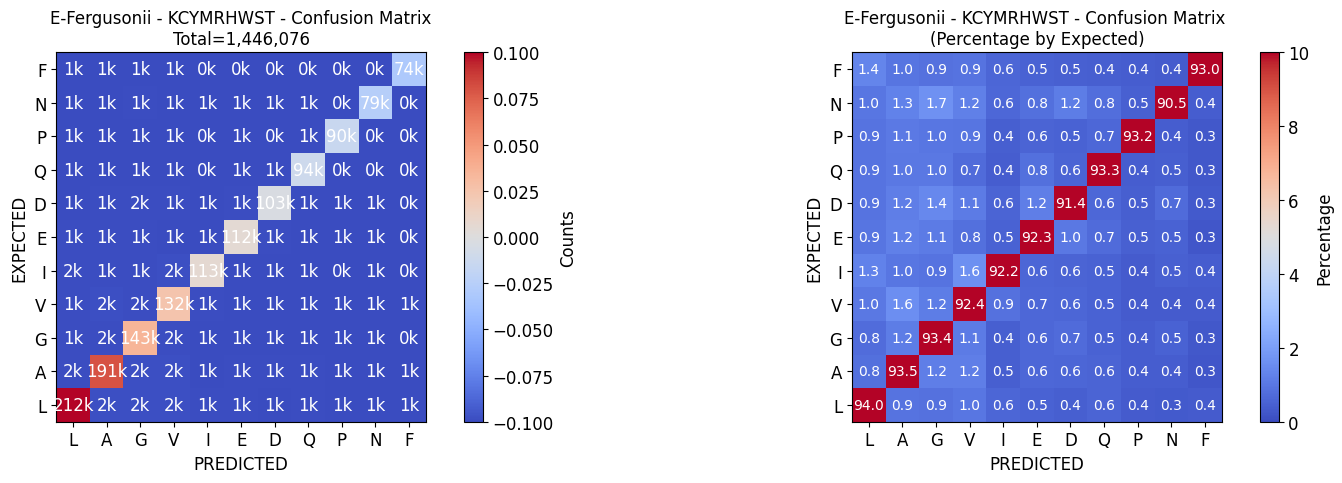

In [37]:
import matplotlib.pyplot as plt
from collections import defaultdict
# import seaborn as sns
# sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

cmap1 = 'coolwarm'
cmap2 = 'coolwarm'

all_AAs = ['K','C','Y','S','R',
            'D','E','M','W','H',
            'N','Q','G','A','V',
            'L','P','I','F','T',
            '_','?','=','*']
order = "[CWHMYFNKPQDRTEISVGAL]" #"[ALDEGVQNSIRTPFKYMHWC]"

m = [ l for l in order if l.isalpha() and l in masking_letters]
all_pairwises = [ ('e'+a,'p'+b) for a in all_AAs for b in all_AAs ]

  
######################################################

TINY_SIZE = 10
SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Create a figure with 3 subplots in a row
fig, axs = plt.subplots(1, 2, figsize=(16,5))



def update_plot(score_range=[0,10], vmap = [0,100]):
    # Clear previous plot
    for ax in axs:
        ax.clear()

    
    # Initialize a 2D numpy array to store the values
    heatmap_data = np.zeros((len(m), len(m)))
    heatmap_data_row = np.zeros((len(m), len(m)))
    heatmap_data_col = np.zeros((len(m), len(m)))

    vmin, vmax = vmap
    lst = []
    for df in all_dfs.values():
        tmp_matrix = np.zeros((len(m), len(m)))
        pairwise_dict = defaultdict(int)
        for _,v in df.iterrows():
            if score_range[0] <= v["Matching Percentage"] and v["Matching Percentage"] <= score_range[1]:
                for c in range(len(v["expected"])):
                    if v['expected'][c] == ' ':
                        continue
                    else:
                        e = v['expected'][c]
                        p = v['predicted'][c] 
                        pairwise_dict[('e'+e,'p'+p)] += 1                

        # Fill the numpy array with values from the dictionary (only considering 8 missing aa, others can be treat as outliers for now)
        for i, char1 in enumerate(m):
            for j, char2 in enumerate(reversed(m)):
                key = ('e'+char1, 'p'+char2)
                if key in pairwise_dict:
                    tmp_matrix[i, j] = pairwise_dict[key]
        lst.append(tmp_matrix)
    heatmap_data = np.mean(np.stack(lst), axis=0)
    
    ########################
    # Plot the first heatmap in the first subplot
    im1 = axs[0].imshow(heatmap_data, cmap=cmap1, interpolation='nearest')
    # annotate
    for i in range(len(m)):
        for j in range(len(m)):
            axs[0].text(j, i, f'{heatmap_data[i, j]/1000:,.0f}k', ha='center', va='center', color='white', fontsize=SMALL_SIZE)

    axs[0].set_title(f'{title} - Confusion Matrix\nTotal={np.sum(heatmap_data):,.0f}')
    axs[0].set_xlabel('PREDICTED')
    axs[0].set_ylabel('EXPECTED')
    im1.set_clim(vmin=heatmap_data.min(), vmax=heatmap_data.max())
    
    ####
    # Calculate row sums
    row_sums = heatmap_data.sum(axis=1)
    # Divide each element in a row by the sum of that row to get percentages
    for i in range(len(m)):
        heatmap_data_row[i, :] = heatmap_data[i, :] *100 /row_sums[i]
        
    ###
    # Plot the second heatmap in the second subplot
    im2 = axs[1].imshow(heatmap_data_row, cmap=cmap2, interpolation='nearest', vmin=vmin, vmax=vmax)
    # annotate
    for i in range(len(m)):
        for j in range(len(m)):
            axs[1].text(j, i, f'{heatmap_data_row[i, j]:,.1f}', 
                        ha='center', va='center', color='white', fontsize=TINY_SIZE)
    axs[1].set_title(f'{title} - Confusion Matrix \n(Percentage by Expected)')
    axs[1].set_xlabel('PREDICTED')
    axs[1].set_ylabel('EXPECTED')
    im2.set_clim(vmin=vmin, vmax=vmax)
    # cbar2.set_clim(vmin=vmin, vmax=vmax)
    
    # Set tick labels for all subplots
    for ax in axs:
        ax.set_xticks(np.arange(len(m)))
        ax.set_yticks(np.arange(len(m)))
        ax.set_yticklabels(m)
        ax.set_xticklabels(reversed(m))
    plt.tight_layout()
    plt.close(fig)
    return fig
    
# Create initial colorbars
cbar1 = fig.colorbar(axs[0].imshow(np.empty((1, 1)), cmap=cmap1), ax=axs[0], label='Counts')
cbar2 = fig.colorbar(axs[1].imshow(np.empty((1, 1)), cmap= cmap2, vmin=0, vmax=10), ax=axs[1], label='Percentage')
update_plot(score_range=[0,100], vmap=[0,10])


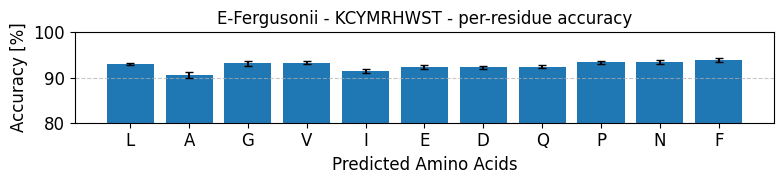

In [38]:
import seaborn as sns
sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)
token_acc_lst = []
for df in all_dfs.values():
  token_acc = {}
  expected_tokens = ''.join(list(df['expected'].astype(str))).replace(' ', '')
  predicted_tokens = ''.join(list(df['predicted'].astype(str))).replace(' ', '')
  token_set = [x for x in reversed(order) if x in m] # freq sorted
  token_dict = { x: [0,0] for x in token_set}
  for e,p in zip(expected_tokens,predicted_tokens):
    token_dict[e][1] +=1
    if e == p:
      token_dict[e][0] +=1

  for k,(v1,v2) in token_dict.items():
    token_acc[k] =v1/v2*100
  token_acc_lst.append(token_acc)

ave_token_acc = {}
ave_token_stdev = {}
for k in m:
  ave_token_acc[k] = np.mean([ d[k] for d in token_acc_lst])
  ave_token_stdev[k] = np.std([ d[k] for d in token_acc_lst])
  
# PRESENTATION OF CATAGORIES' ACCURACY

_, ax1 = plt.subplots(1,1,figsize=(8,2))

# -- TOKEN-WISE
ax1.bar(range(len(token_set)),ave_token_acc.values(), yerr=ave_token_stdev.values(), capsize=3)#, color='teal')

# Set labels and title
ax1.set_xlabel('Predicted Amino Acids')
ax1.set_ylabel('Accuracy [%]')
ax1.set_title(f'{title} - per-residue accuracy')
ax1.set_xticks(range(len(token_set)),token_set)
ax1.set_ylim([80,100])
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)
# -----

plt.tight_layout()
plt.show()